In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-events-history-in-cosmetics-shop/2019-Nov.csv
/kaggle/input/ecommerce-events-history-in-cosmetics-shop/2020-Feb.csv
/kaggle/input/ecommerce-events-history-in-cosmetics-shop/2019-Oct.csv
/kaggle/input/ecommerce-events-history-in-cosmetics-shop/2019-Dec.csv
/kaggle/input/ecommerce-events-history-in-cosmetics-shop/2020-Jan.csv


**Lets import all the necessary packages that we are going to use**

In [2]:
import plotly.express as px 
import os
import matplotlib.pyplot as plt
import missingno as msno
import datetime
from plotly import graph_objects as go
from plotly.subplots import make_subplots

This notebook consists of some Exploratory data analysis, Basic web analysis and data visualisation. For simplicity, will be using only Jan data.

In [3]:
data=pd.read_csv('../input/ecommerce-events-history-in-cosmetics-shop/2020-Jan.csv')

In [4]:
data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-01-01 00:00:00 UTC,view,5809910,1602943681873052386,NaN,grattol,5.24,595414620,4adb70bb-edbd-4981-b60f-a05bfd32683a
1,2020-01-01 00:00:09 UTC,view,5812943,1487580012121948301,NaN,kinetics,3.97,595414640,c8c5205d-be43-4f1d-aa56-4828b8151c8a
2,2020-01-01 00:00:19 UTC,view,5798924,1783999068867920626,NaN,zinger,3.97,595412617,46a5010f-bd69-4fbe-a00d-bb17aa7b46f3
3,2020-01-01 00:00:24 UTC,view,5793052,1487580005754995573,NaN,NaN,4.92,420652863,546f6af3-a517-4752-a98b-80c4c5860711
4,2020-01-01 00:00:25 UTC,view,5899926,2115334439910245200,NaN,NaN,3.92,484071203,cff70ddf-529e-4b0c-a4fc-f43a749c0acb


Event_time column has string "UTC" in it. So split the actual datetime and UTC seperate. Then convert the Event_time column into datetime datatype. Also, create new columns called date,time,hour,weekday,weeknum from the "event_time" column. Lets also change the weekday format from number to string like mon,tues,etc..

In [5]:
#seperating timezone
data["timezone"]= data["event_time"].str.rsplit(" ", n=1,expand = True)[1]
data["event_time"]= data["event_time"].str.rsplit(" ", n=1,expand = True)[0]
data["event_time"]=pd.to_datetime(data["event_time"])

#creating date,time,hours,weekday,weeknum columns
data["date"]=data['event_time'].dt.date
data["time"]=data['event_time'].dt.time
data["hours"]=data['event_time'].dt.hour
data["weekday"]=data['event_time'].dt.weekday
data['weeknum']=data['event_time'].dt.isocalendar().week

#changing weekday to string and adding 'week_' prefix to weeknum
data['weeknum'] = 'week_' + data['weeknum'].astype(str)
data['weekday']= data['weekday'].replace({0:'Sun',1:'Mon',2:'Tues',3:'Wed',4:'Thurs',5:'Fri',6:'Sat'})

In [6]:
data.head()


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,timezone,date,time,hours,weekday,weeknum
0,2020-01-01 00:00:00,view,5809910,1602943681873052386,NaN,grattol,5.24,595414620,4adb70bb-edbd-4981-b60f-a05bfd32683a,UTC,2020-01-01,00:00:00,0,Tues,week_1
1,2020-01-01 00:00:09,view,5812943,1487580012121948301,NaN,kinetics,3.97,595414640,c8c5205d-be43-4f1d-aa56-4828b8151c8a,UTC,2020-01-01,00:00:09,0,Tues,week_1
2,2020-01-01 00:00:19,view,5798924,1783999068867920626,NaN,zinger,3.97,595412617,46a5010f-bd69-4fbe-a00d-bb17aa7b46f3,UTC,2020-01-01,00:00:19,0,Tues,week_1
3,2020-01-01 00:00:24,view,5793052,1487580005754995573,NaN,NaN,4.92,420652863,546f6af3-a517-4752-a98b-80c4c5860711,UTC,2020-01-01,00:00:24,0,Tues,week_1
4,2020-01-01 00:00:25,view,5899926,2115334439910245200,NaN,NaN,3.92,484071203,cff70ddf-529e-4b0c-a4fc-f43a749c0acb,UTC,2020-01-01,00:00:25,0,Tues,week_1


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4264752 entries, 0 to 4264751
Data columns (total 15 columns):
 #   Column         Dtype         
---  ------         -----         
 0   event_time     datetime64[ns]
 1   event_type     object        
 2   product_id     int64         
 3   category_id    int64         
 4   category_code  object        
 5   brand          object        
 6   price          float64       
 7   user_id        int64         
 8   user_session   object        
 9   timezone       object        
 10  date           object        
 11  time           object        
 12  hours          int64         
 13  weekday        object        
 14  weeknum        object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(9)
memory usage: 488.1+ MB


As we can see from above info() method, all the datatypes are correctly available. Hours is available as int64. Since hours is only used for grouping and other data analysis related works, its okay to have it in int64 format. Lets quickly check the minimum, average, maximum and other statics related to the numerical columns.

In [8]:
data.describe()

,product_id,category_id,price,user_id,hours
count,4.264752e+06,4.264752e+06,4.264752e+06,4.264752e+06,4.264752e+06
mean,5.492516e+06,1.558391e+18,8.713981e+00,5.335230e+08,1.334506e+01
std,1.291503e+06,1.749208e+17,1.963959e+01,8.781433e+07,5.483573e+00
min,3.752000e+03,1.487580e+18,-7.937000e+01,4.654960e+05,0.000000e+00
25%,5.724662e+06,1.487580e+18,2.350000e+00,4.955007e+08,9.000000e+00
50%,5.811708e+06,1.487580e+18,4.060000e+00,5.668305e+08,1.400000e+01
75%,5.859408e+06,1.487580e+18,7.140000e+00,5.983049e+08,1.800000e+01
max,5.924514e+06,2.235524e+18,3.277800e+02,6.088221e+08,2.300000e+01


We can see that there are some entries which have negative prices. This might be a return orders. Lets just try to see how many orders are returned.

In [9]:
returned_orders=data[data['price']<0]['price'].count()
returned_orders_perc=returned_orders/(data['price'].count())

print("There are %2d returned orders which is %.5f of total orders." %(returned_orders,round(returned_orders_perc,5)))

There are 39 returned orders which is 0.00001 of total orders.


0.00001% almost negligible.Might be result of poor data mining. Lets remove those records and save our dataset.

In [10]:
data=data[data['price']>=0]

#Checkinng how much missing values are present in the dataset.

# Calculate the Percentage of missing values in All columns
perc=data.isnull().sum() * 100 / len(data)
print(round(perc,2))

event_time        0.00
event_type        0.00
product_id        0.00
category_id       0.00
category_code    98.25
brand            41.63
price             0.00
user_id           0.00
user_session      0.03
timezone          0.00
date              0.00
time              0.00
hours             0.00
weekday           0.00
weeknum           0.00
dtype: float64


We can clearly see that Category_code and brand has majority of missing values. user_session has very minimal missing value. Lets visually see the missing value in the dataframe as follows:

<AxesSubplot:>

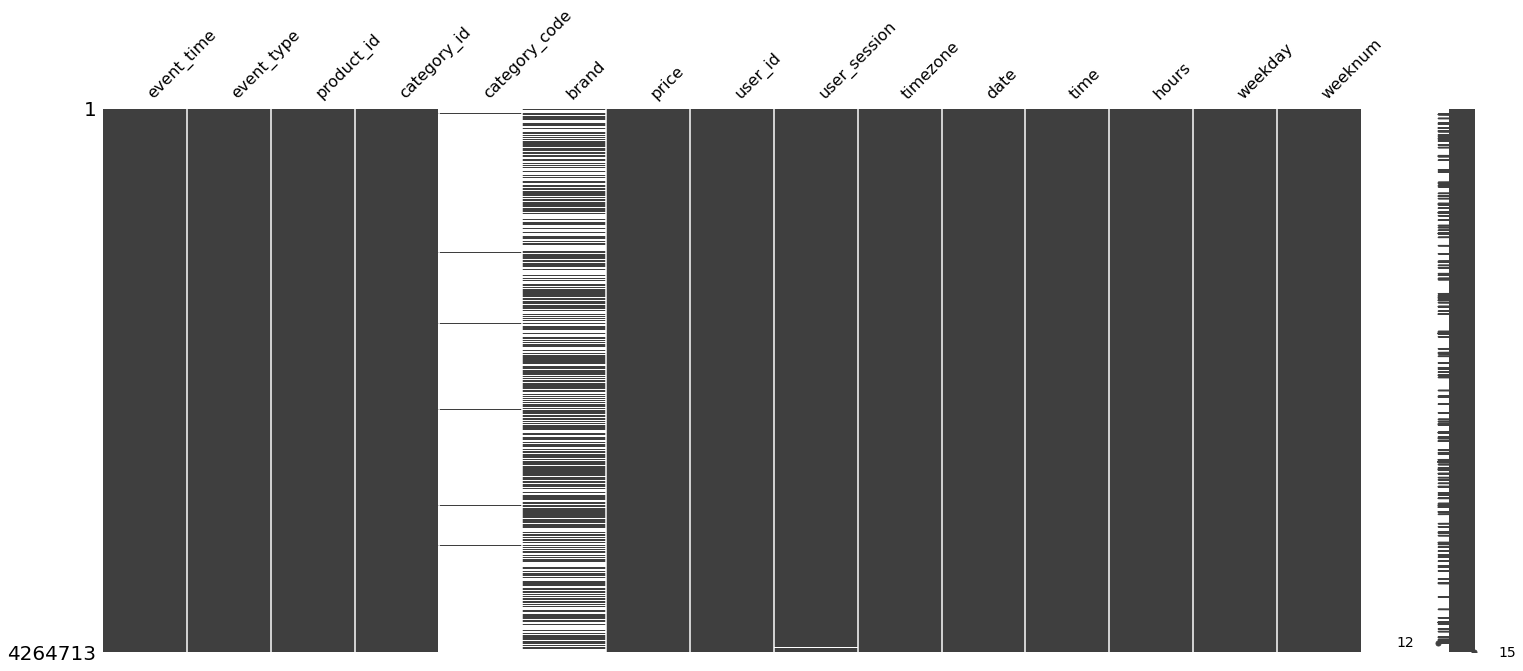

In [11]:
#Visualising in matrix form
msno.matrix(data)

<AxesSubplot:>

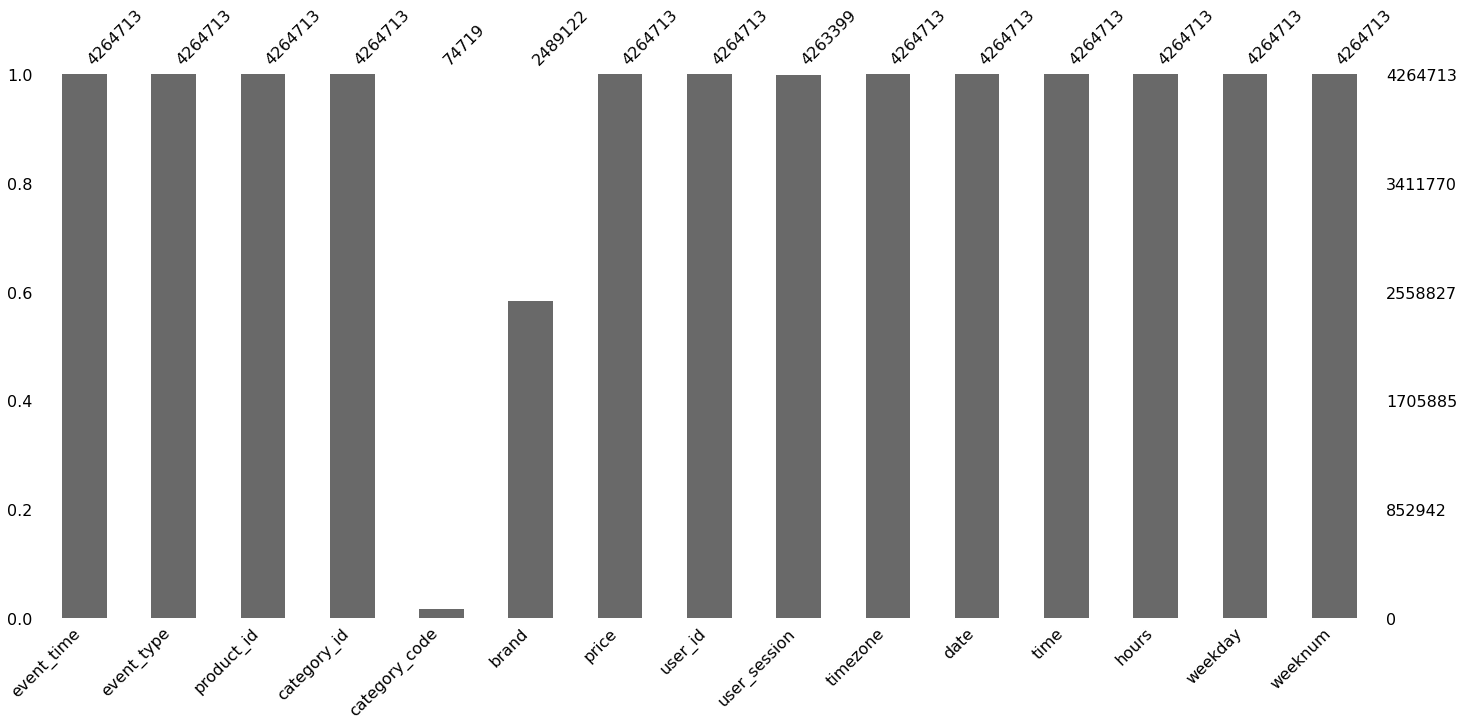

In [12]:
#Visualising as bar graph
msno.bar(data)

Lets check the number of Unique values in the dataframe

In [13]:
#checking number of unique values in dataframe
data.nunique()

event_time       1811716
event_type             4
product_id         45479
category_id          482
category_code         12
brand                256
price               2092
user_id           410073
user_session      965350
timezone               1
date                  31
time               86400
hours                 24
weekday                7
weeknum                5
dtype: int64

We can see that there are only 4 types of event_types in the data. So lets check the differnt types and will create a data funnel as how customers will go thorugh the purchase funnel.

In [14]:
data.event_type.unique()

array(['view', 'cart', 'remove_from_cart', 'purchase'], dtype=object)

As we can see there are four event_types out of which "Remove_from_cart" is a event which all users might not go through during their journey. So lets remove that particular event before we group and make our data ready for visualising the funnel

In [15]:
#grouping and preparing data for funnel visualisation

data_funnel=data[data['event_type']!='remove_from_cart'].groupby(['event_type'],as_index=False)['event_time'].count()
data_funnel.columns=['event_type','# events']
data_funnel.sort_values('# events', inplace=True,ascending=False)
data_funnel.reset_index(drop=True,inplace=True)
data_funnel['percent']=data_funnel['# events']/(data_funnel['# events'][0].sum())*100
data_funnel

,event_type,# events,percent
0,view,2037606,100.000000
1,cart,1148323,56.356479
2,purchase,263761,12.944652


Now lets use plotly too visualise the customer funnel

In [16]:
#plotly to visualise funnel
fig = go.Figure(go.Funnel(
    y = data_funnel["event_type"],
    x = data_funnel["# events"],
    customdata=data_funnel["percent"],
    texttemplate= "<b>%{label}: </B>%{value:.2s}"+"<br><b>% of Total:</b> %{customdata:.2f}%",
    textposition='inside',
    marker = {"color": ["lightyellow", "lightsalmon", "tan"]}
    ))
fig.update_yaxes(visible=False)
fig.update_layout(template='simple_white',     
                  title={'xanchor': 'center',
                         'yanchor': 'top',        
                         'y':0.9,
                         'x':0.5,
                         'text':"Customer Funnel for Purchase Journey"})
fig.show()

In [17]:
datahour=data.groupby(['hours','weeknum'],as_index=False)['price'].count()
datahour.columns=['hours','weeknum','price']
fig = px.area(datahour, x='hours', y="price",color='weeknum')
fig.update_layout(template='simple_white',     
                title={'xanchor': 'center',
                         'yanchor': 'top',        
                         'y':0.9,
                         'x':0.5,
                         'text':"Customer's Hourly Website Views"},
                xaxis = dict(
                    title_text='hours',
                    tickmode = 'linear',
                    tick0 = 0,
                    dtick = 2),
                 yaxis = dict(
                    title_text='Visitors'))
fig.show()

As we can see from the above graph, there are usually two peaks in a day which happens around 10 AM to 2PM and then again the peak starts from 6PM to 8PM. Knowing the marketing spent through out the day, and conversion rate arouund these hours, we can target campaigns (especially conversion campaigns) to run specifically targeting highly converting hours.

This peak hours generally translates to lunch break, and post work. Thus having high traffic at these hours makes sense.

In [18]:
datadate=data[data['event_type']=='purchase'].groupby(['date'],as_index=False)['price'].sum()
datadateh=data[data['event_type']=='purchase'].groupby(['date'],as_index=False)['price'].count()
datadateh['avg_ticket']=datadate['price']/datadateh['price']
datadate.columns=['date','price']

fig = make_subplots(
    rows=2, cols=1,
    column_widths=[1.0],
    row_heights=[0.5, 0.5],
    specs=[[{"type": "Bar"}],
           [{"type": "Scatter"}]])

fig.add_trace(go.Bar(x=datadate['date'], y=datadate["price"],name='Sales'),
             row=1,col=1)
fig.add_trace(go.Scatter(x=datadateh['date'], y=datadateh['price'],
                    mode='lines+markers',
                    name='No of Purchases'),
              row=1,col=1)
fig.add_trace(go.Scatter(x=datadateh['date'], y=datadateh['avg_ticket'],
                    mode='lines+markers',
                    name='Avg Ticket Size'),
              row=2,col=1)
fig.update_layout(template='simple_white',     
                title={'xanchor': 'center',
                         'yanchor': 'top',        
                         'y':0.9,
                         'x':0.5,
                         'text':"Daily sales"}
                 )
fig.update_yaxes(title_text='Sales/No of Purchases',ticks="inside", row=1)
fig.update_yaxes(title_text='Avg Ticket Size',ticks="inside", row=2)
fig.update_xaxes(title_text='Date',ticks="inside")
fig.show()

As we can see from above graph, there are two peaks when sales were high. This happened on Jan 27th and Jan 28th,2020. This might be due to some specific promotional campaigns.The number of sales is also high on these days but the average ticket size is not that low by which we can infer that,even if there is any promotional campaigns running on Jan 27 and Jan 28, the discount is not that low affecting the average ticket size.

In [19]:
#preprare data for further Visualisation
datadatehour=data[data['event_type']=='purchase'].groupby(['date','hours'],as_index=False)['price'].sum()
datadatehour.columns=['date','hours','price']
datadatehour['hours']=datadatehour['hours'].astype(str)
datadatehour['date']=datadatehour['date'].astype(str)

In [20]:
fig = make_subplots(
    rows=2, cols=1,
    column_widths=[1.0],
    row_heights=[0.5, 0.5],
    specs=[[{"type": "histogram2d"}],
           [{"type": "histogram2dcontour"}]])
fig.add_trace(
    go.Histogram2d(
        x = datadatehour["date"],
        y = datadatehour["hours"],
        z = datadatehour["price"],
        colorbar=dict(len=0.5, y=0.8,title="Overall Sales"),
        histfunc = "sum",
        colorscale = "cividis",
        nbinsx = 31,
        nbinsy=24),
    row=1,col=1)
fig.add_trace(
    go.Histogram2dContour(
        x = datadatehour["date"],
        y = datadatehour["hours"],
        z = datadatehour["price"],
        colorbar=dict(len=0.5, y=0.25,title="Overall Sales",tickmode="array",
        tickvals=[20000,40000,60000,80000,100000,120000],),
        histfunc = "sum",
        showlegend=False,
        colorscale = "cividis",
        contours = dict(
            showlabels = True),
        nbinsx=31,
        nbinsy=24),
    row=2,col=1)


fig.update_layout(
    template="simple_white",
    margin=dict(r=50, t=50, b=50, l=50),
    height=600,
    showlegend=False,
    title={'xanchor': 'center',
           'yanchor': 'top',        
            'y':1,
            'x':0.5,
           'text':"Heatmap vs Contourplot</br></br></br>Hourly sales during Jan"}
)
fig.update_yaxes(title_text='Hours',ticks="inside")
fig.update_xaxes(title_text='Date',ticks="inside")
fig.show()

We can confirm the same high volume of sales on Jan 27th and 28th in above countour or heatmap as well. From above visualisation, it is also clear that generally the sales happen around 9AM to 1PM. But in last week, there are sales happening in the evening as well.

In [21]:
fig = make_subplots(
    rows=2, cols=1,
    column_widths=[1.0],
    row_heights=[0.5, 0.5],
    specs=[[{"type": "histogram2d"}],
           [{"type": "histogram2dcontour"}]])
fig.add_trace(
    go.Histogram2d(
        x = datahour["hours"],
        y = datahour["weeknum"],
        z = datahour["price"],
        colorbar=dict(len=0.5, y=0.8,title="Overall Sales"),
        histfunc = "sum",
        colorscale='cividis',
        nbinsx = 31,
        nbinsy=7
    ),
    row=1,col=1)
fig.add_trace(
    go.Histogram2dContour(
        x = datahour["hours"],
        y = datahour["weeknum"],
        z = datahour["price"],
        colorbar=dict(len=0.5, y=0.20,title="Overall Sales",tickmode="array",
        tickvals=[20000,40000,60000],
                     ),
        histfunc = "sum",
        showlegend=False,
        colorscale='cividis',
        contours = dict(
            showlabels = True),
        nbinsx=31,
        nbinsy=7
    ),
    row=2,col=1)


fig.update_layout(
    template="simple_white",
    margin=dict(r=50, t=50, b=50, l=50),
    height=600,
    showlegend=False,
    title={'xanchor': 'center',
           'yanchor': 'top',        
            'y':0.999,
            'x':0.5,
           'text':"Heatmap vs Contourplot</br></br></br>Hourly sales by weekdays"}
)
fig.update_yaxes(title_text='Weekdays',ticks="inside")
fig.update_xaxes(title_text='Hours',ticks="inside")
fig.show()

When we combine sales weekwise and visualise, as we already predicted sales happen around 9AM to 2PM in the morning and in evening from 4PM To 8PM (mmajorly from 6PM to 8PM)

When combining weekly sales, majority of sales happened in week3 and week4 ( because in January 2020, there are 4 days in week1 and 6days in week5 and rest of the week has 7 days. If we compensate the one missing day in week5, we will have higher sales in last week as well.

In [22]:
data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,timezone,date,time,hours,weekday,weeknum
0,2020-01-01 00:00:00,view,5809910,1602943681873052386,NaN,grattol,5.24,595414620,4adb70bb-edbd-4981-b60f-a05bfd32683a,UTC,2020-01-01,00:00:00,0,Tues,week_1
1,2020-01-01 00:00:09,view,5812943,1487580012121948301,NaN,kinetics,3.97,595414640,c8c5205d-be43-4f1d-aa56-4828b8151c8a,UTC,2020-01-01,00:00:09,0,Tues,week_1
2,2020-01-01 00:00:19,view,5798924,1783999068867920626,NaN,zinger,3.97,595412617,46a5010f-bd69-4fbe-a00d-bb17aa7b46f3,UTC,2020-01-01,00:00:19,0,Tues,week_1
3,2020-01-01 00:00:24,view,5793052,1487580005754995573,NaN,NaN,4.92,420652863,546f6af3-a517-4752-a98b-80c4c5860711,UTC,2020-01-01,00:00:24,0,Tues,week_1
4,2020-01-01 00:00:25,view,5899926,2115334439910245200,NaN,NaN,3.92,484071203,cff70ddf-529e-4b0c-a4fc-f43a749c0acb,UTC,2020-01-01,00:00:25,0,Tues,week_1


In order to find the average ticket size, averge number of purchases by user, lets group the data by user_id.

In [23]:
#grouping based on user_id,date,hours,weekday,weeknum
data_user=data[data['event_type']=='purchase'].groupby(['user_id','date','hours','weekday','weeknum']).agg({'price':['sum','count']}).reset_index()

#converting columns from multi index to single index
data_user.columns=data_user.columns.to_flat_index()
data_user=data_user.rename(columns={('price', 'sum'):'purchased_value',('price', 'count'):'no_of_purchases',('user_id',''):'user_id',
                          ('date',''):'date',('hours',''):'hours',('weekday',''):'weekday',('weeknum',''):'weeknum'})

#checking whether columns are updated correctly
data_user.head()

,user_id,date,hours,weekday,weeknum,purchased_value,no_of_purchases
0,10280338,2020-01-12,22,Sat,week_2,18.10,1
1,12936739,2020-01-17,7,Thurs,week_3,29.89,2
2,20554973,2020-01-15,16,Tues,week_3,21.81,7
3,23633626,2020-01-28,9,Mon,week_5,22.13,8
4,27443691,2020-01-27,6,Sun,week_5,29.12,5


In [24]:
fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.5, 0.5],
    row_heights=[1.0],
    specs=[[{"type": "Violin"},
           {"type": "Violin"}]])
fig = fig.add_trace(go.Violin(y=data_user['no_of_purchases'],
                            name='No of Purchases',
                            box_visible=True,
                            meanline_visible=True),
                       row=1,col=1)
fig = fig.add_trace(go.Violin(y=data_user['purchased_value'],
                            name='Ticked Size',
                            box_visible=True,
                            meanline_visible=True),
                       row=1,col=2)
fig.update_layout(
    template="simple_white",
    margin=dict(r=50, t=50, b=50, l=50),
    height=600,
    showlegend=False,
    yaxis_title="Count",
    title={'xanchor': 'center',
           'yanchor': 'top',        
            'y':0.95,
            'x':0.5,
           'text':"Summary Statistics for Number of Purchases and Ticket size of purchases"}
)
fig.show()

As we can see from above graph, on average 8 products have been purchased where as 50% of people have purchased 6 products in the month of January. 25%(since INR Q3 is 10) of people have atleast purchased 10 products. Similarly, on average, the ticket size is 40.7 𝑎𝑛𝑑50 . 25%(since INR Q3 is 10) of people have spent minimum of 50.1$ as ticket size.


***This notebook I have created to practice Explarotary data analysis and to practise some data visualisation. Feel free to share your feedbacks with me.***